In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from finsde.models.sde import LatentSDE
from finsde.models.discrete_sde import DiscreteLatentSDE
from finsde.core import FinSDELightningModule
from finsde.utils.dataloader import SingleStockDataset, SingleStockDataModule

In [3]:
from pathlib import Path
import matplotlib

In [4]:
font_dir = Path("../fonts")
for font_path in font_dir.glob("*.ttf"):
    print(font_path)
    matplotlib.font_manager.fontManager.addfont(font_path)

../fonts/Arial.ttf
../fonts/Arial_Italic.ttf
../fonts/Arial_Black.ttf
../fonts/Arial_Bold.ttf
../fonts/Arial_Bold_Italic.ttf


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from omegaconf import OmegaConf
import hydra

OmegaConf.register_new_resolver("eval", eval)

In [6]:
run_dir = Path("../scripts/results/run-2025-04-17_17-37-23")
pl_module_class = FinSDELightningModule
cfg_path = run_dir / "config.yaml"
cfg = OmegaConf.load(cfg_path)

In [7]:
checkpoint_type = "last"

checkpoint_dir = run_dir / "checkpoints"
if checkpoint_type == "best":
    checkpoint_path = sorted(checkpoint_dir.glob("epoch=*.ckpt"))[-1]
elif checkpoint_type == "last":
    checkpoint_path = checkpoint_dir / "last.ckpt"

In [8]:
model_cfg = cfg.model.copy()
del model_cfg._target_
kwargs = hydra.utils.instantiate(model_cfg)
pl_module = pl_module_class.load_from_checkpoint(
    checkpoint_path,
    **kwargs
)
pl_module.model.eval()

/data/user_data/fcpei/miniconda3/envs/finsde/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


DiscreteLatentSDE(
  (encoder): Encoder(
    (gru): GRU(6, 64, num_layers=2, bidirectional=True)
    (qz0_net): Linear(in_features=256, out_features=12, bias=True)
    (lin): Linear(in_features=128, out_features=32, bias=True)
  )
  (f_net): Sequential(
    (0): Linear(in_features=38, out_features=64, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
  (h_net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
  (g_net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=64, out_features=6, bias=Tru

In [9]:
datamodule_cfg = cfg.datamodule.copy()
datamodule = hydra.utils.instantiate(datamodule_cfg)
datamodule.setup("")

# get original datasets from ConcatDataset of Subsets
dataset_list = [d.dataset for d in datamodule.train_dataset.datasets]

In [10]:
stride = 25

torch.manual_seed(0)

dataset_predictions = {}
for dataset in dataset_list:
    # initialize buffers
    dataset_xs = []
    dataset_zs = []
    dataset_drifts = []
    dataset_divergences = []
    dataset_diffusions = []
    dataset_mses = []
    dataset_res = []
    # set up loop
    samples = list(range(0, len(dataset), stride))
    if samples[-1] != len(dataset) - 1:
        samples.append(len(dataset) - 1)
    # iterate over samples
    for i in range(len(samples)):
        # sample trajectory
        idx = samples[i]
        x, y = dataset[idx]
        x = x.unsqueeze(0)
        ts_in = torch.arange(0, x.shape[1], device=x.device) / x.shape[1]
        ts_out = torch.arange(0, x.shape[1] + y.shape[0], device=x.device) / x.shape[1]
        with torch.no_grad():
            ys, _, _, zs = pl_module(x.permute(1, 0, 2), ts_in, ts_out, **pl_module.forward_kwargs, return_trajectory=True)
        zs = zs[:x.shape[1]]
        with torch.no_grad():
            xs = pl_module.model.mu_projector(zs)
        drift = []
        divergence = []
        for j in range(zs.shape[0]):
            def get_drift(z):
                return pl_module.model.f(ts_out[j], z.unsqueeze(0).unsqueeze(0)).squeeze()
            drift_i = get_drift(zs[j].squeeze()).unsqueeze(0).unsqueeze(0)
            div_i = torch.linalg.det(torch.autograd.functional.jacobian(get_drift, zs[j].squeeze())).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            drift.append(drift_i)
            divergence.append(div_i)
        drift = torch.cat(drift, dim=0)
        divergence = torch.cat(divergence, dim=0)
        with torch.no_grad():
            diffusion = torch.stack([
                pl_module.model.g(ts_out[j], zs[[j]])[0]
                for j in range(zs.shape[0])
            ], dim=0)
        zs = zs.squeeze(1)
        xs = xs.squeeze(1)
        drift = drift.squeeze(1)
        divergence = divergence.squeeze(1)
        diffusion = diffusion.squeeze(1)
        mse = torch.nn.functional.mse_loss(ys.permute(1, 0, 2).reshape(y.shape)[..., 0], y[..., 0])
        relative_error = torch.mean(torch.abs((ys.permute(1, 0, 2).reshape(y.shape)[..., 0] - y[..., 0]) / torch.clamp(y[..., 0], min=1e-6)))
        # store trajectory
        if i == 0:
            dataset_xs.append(xs)
            dataset_zs.append(zs)
            dataset_drifts.append(drift)
            dataset_divergences.append(divergence)
            dataset_diffusions.append(diffusion)
        else:
            overlap = samples[i - 1] + 50 - samples[i]
            drop = 0
            if overlap > dataset_xs[-1].shape[0]:
                drop = overlap - dataset_xs[-1].shape[0]
                overlap = dataset_xs[-1].shape[0]
            weighting = torch.linspace(0, 1, overlap).unsqueeze(1)
            for buffer, arr in zip(
                [dataset_xs, dataset_zs, dataset_drifts, dataset_divergences, dataset_diffusions],
                [xs, zs, drift, divergence, diffusion]
            ):
                buffer[-1][-overlap:] = buffer[-1][-overlap:] * (1 - weighting) + arr[drop:overlap+drop] * weighting
                buffer.append(arr[overlap+drop:])
        dataset_mses.append(torch.tensor([[idx, mse]]))
        dataset_res.append(torch.tensor([[idx, relative_error]]))
    # concatenate buffers
    dataset_xs = torch.cat(dataset_xs, dim=0)
    dataset_zs = torch.cat(dataset_zs, dim=0)
    dataset_drifts = torch.cat(dataset_drifts, dim=0)
    dataset_divergences = torch.cat(dataset_divergences, dim=0)
    dataset_diffusions = torch.cat(dataset_diffusions, dim=0)
    dataset_mses = torch.cat(dataset_mses, dim=0)
    dataset_res = torch.cat(dataset_res, dim=0)
    dataset_predictions[Path(dataset.csv_file).stem] = {
        "xs": dataset_xs,
        "zs": dataset_zs,
        "drifts": dataset_drifts,
        "divergences": dataset_divergences,
        "diffusions": dataset_diffusions,
        "mses": dataset_mses,
        "res": dataset_res,
    }

In [11]:
print(np.argsort([len(ds) for ds in dataset_list])[::-1])
print([dataset_list[i].csv_file.stem for i in np.argsort([len(ds) for ds in dataset_list])[::-1]])
dataset_list_good = [ds for ds in dataset_list if len(ds) > 3500]
# dataset_list_good = [dataset_list[28]]

[24 45 49 28 21 14  7 26 29 10 35 13 15 34 32 17 42 37  4  9  8 23 16  0
 44 46 22  2 38 31  6 11 36 47 40 18  3 27 39 12 48 25 20 33 41 30 43  1
 19  5]
['GLD', 'USO', 'XLF', 'KO', 'EBAY', 'CMG', 'BHP', 'GSK', 'MRK', 'BRK-B', 'PEP', 'CMCSA', 'COP', 'ORCL', 'NKE', 'CRM', 'TM', 'QCOM', 'AMGN', 'BIIB', 'BIDU', 'GILD', 'COST', 'AAL', 'TSM', 'V', 'GE', 'ABBV', 'QQQ', 'MU', 'BABA', 'C', 'PYPL', 'WFC', 'T', 'CVX', 'AMD', 'INTC', 'SBUX', 'CAT', 'WMT', 'GOOG', 'DIS', 'NVDA', 'TGT', 'MSFT', 'TSLA', 'AAPL', 'DAL', 'AMZN']


In [12]:
len(dataset_list_good)

7

In [15]:
diffusion_list = []
mse_list = []
divergence_list = []
for dataset in dataset_list_good:
    df = pd.read_csv(dataset.csv_file)
    diffusion = dataset_predictions[Path(dataset.csv_file).stem]["diffusions"].mean(axis=-1).squeeze().detach().cpu().numpy()
    mse = dataset_predictions[Path(dataset.csv_file).stem]["mses"].detach().cpu().numpy()
    divergence = dataset_predictions[Path(dataset.csv_file).stem]["divergences"].mean(axis=-1).squeeze().detach().cpu().numpy()

    diffusion_list.append(pd.DataFrame(dict(
        diffusion=diffusion,
        date=df["Date"].iloc[:len(diffusion)],
    )))
    divergence_list.append(pd.DataFrame(dict(
        divergence=divergence,
        date=df["Date"].iloc[:len(divergence)],
    )))
    mse_list.append(pd.DataFrame(dict(
        mse=mse[:, 1],
        date=df["Date"].iloc[mse[:, 0].astype(int)],
    )))

diffusion_df = pd.concat(diffusion_list, axis=0)
divergence_df = pd.concat(divergence_list, axis=0)
mse_df = pd.concat(mse_list, axis=0)

diffusion_df = diffusion_df.groupby("date").mean().reset_index()
divergence_df = divergence_df.groupby("date").mean().reset_index()
mse_df = mse_df.groupby("date").mean().reset_index()

In [16]:
vix = pd.read_csv("../../data/VIX_History.csv")

In [17]:
df = diffusion_df.copy()

In [18]:
mask = pd.to_datetime(vix["DATE"], utc=True).isin(pd.to_datetime(df["date"], utc=True))
vix = vix[mask]

In [19]:
mask = pd.to_datetime(df["date"], utc=True).isin(pd.to_datetime(vix["DATE"], utc=True))
df = df[mask]

In [20]:
df = df.set_index(pd.to_datetime(df["date"], utc=True))
vix = vix.set_index(pd.to_datetime(vix["DATE"], utc=True))

In [21]:
df.shape

(3686, 2)

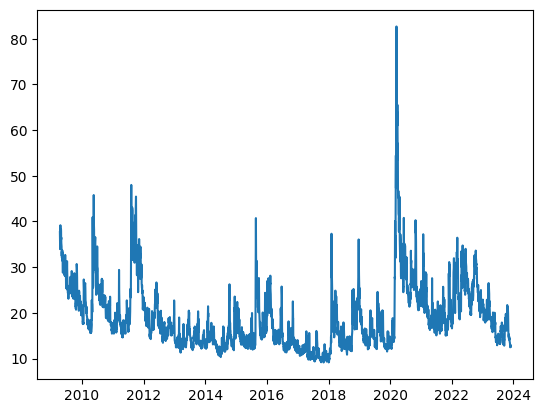

In [22]:
plt.plot(vix["CLOSE"])

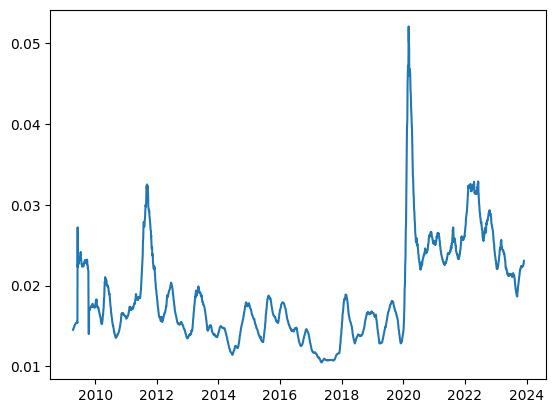

In [23]:
plt.plot(df["diffusion"])

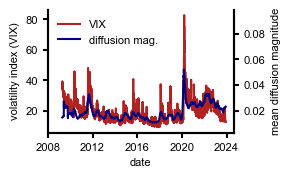

In [24]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

with plt.rc_context(fname="../.matplotlibrc"):
    plt.rcParams["axes.spines.right"] = True
    fig, ax = plt.subplots(1, 1, figsize=(3 * 0.8, 2 * 0.8))
    ax.plot(vix["CLOSE"], label="VIX", color="firebrick")
    ax.plot(np.nan, np.nan, label="diffusion mag.", color="navy")
    lr = LinearRegression()
    lr.fit(df["diffusion"].values.reshape(-1, 1), vix["CLOSE"].values)
    pred = lr.predict(df["diffusion"].values.reshape(-1, 1))
    ax_alt = ax.twinx()
    ax_alt.plot(df["diffusion"], color="navy")
    y_min, y_max = ax.get_ylim()
    y_min = (y_min - lr.intercept_) / lr.coef_[0]
    y_max = (y_max - lr.intercept_) / lr.coef_[0]
    ax_alt.set_ylim(y_min, y_max)
    # plt.xticks()
    xticks, xticklabels = plt.xticks()
    ax.set_xticks(xticks[::2])
    ax.set_xticklabels(xticklabels[::2])
    ax.set_ylabel("volatility index (VIX)")
    ax.set_xlabel("date")
    ax_alt.set_ylabel("mean diffusion magnitude")
    ax.legend()
    plt.savefig("volatility_diffusion.png", bbox_inches="tight", dpi=300)
    plt.savefig("volatility_diffusion.pdf", bbox_inches="tight", dpi=300)
    plt.show()

In [25]:
vix = pd.read_csv("../../data/VIX_History.csv")

results = dict()
for label, key, df in zip(
    ["diffusion", "drift jac. det.", "mse"],
    ["diffusion", "divergence", "mse"],
    [diffusion_df, divergence_df, mse_df]
):
    mask = pd.to_datetime(vix["DATE"], utc=True).isin(pd.to_datetime(df["date"], utc=True))
    vix_matched = vix[mask]

    mask = pd.to_datetime(df["date"], utc=True).isin(pd.to_datetime(vix_matched["DATE"], utc=True))
    df = df[mask]

    df = df.set_index(pd.to_datetime(df["date"], utc=True))
    vix_matched = vix_matched.set_index(pd.to_datetime(vix_matched["DATE"], utc=True))

    results[label] = pearsonr(df[key], vix_matched["CLOSE"])[0]

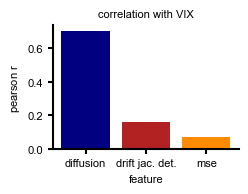

In [26]:
with plt.rc_context(fname="../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3 * 0.8, 2 * 0.8))
    ax.bar(results.keys(), results.values(), color=["navy", "firebrick", "darkorange"])
    # plt.xticks()
    ax.set_ylabel("pearson $r$")
    ax.set_xlabel("feature")
    ax.set_title("correlation with VIX")
    plt.savefig("volatility_diffusion_correlation.png", bbox_inches="tight", dpi=300)
    plt.savefig("volatility_diffusion_correlation.pdf", bbox_inches="tight", dpi=300)
    plt.show()

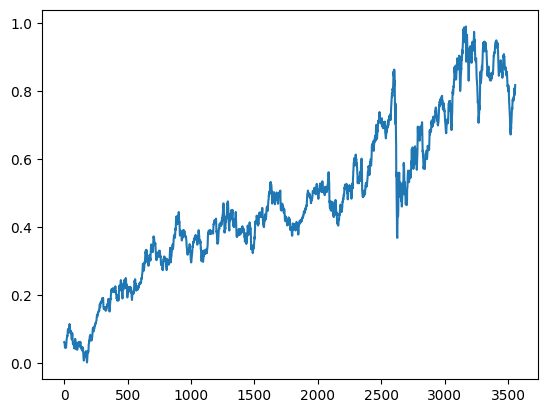

In [28]:
plt.plot(dataset_predictions[Path(dataset_list[28].csv_file).stem]["xs"][..., 0].squeeze())

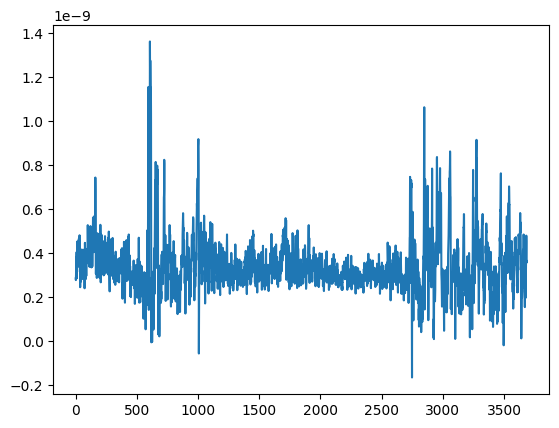

In [99]:
plt.plot(dataset_predictions[Path(dataset_list[idx].csv_file).stem]["divergences"].mean(dim=-1))

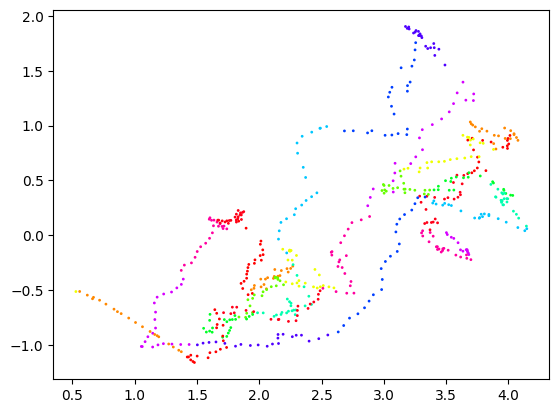

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

idx = 28
w0 = 0
w1 = 600
# c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["xs"][..., 0].squeeze().detach().numpy()
c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["diffusions"].mean(dim=-1).squeeze().detach().numpy()
c = pd.to_datetime(pd.read_csv(dataset_list[idx].csv_file)['Date']).dt.month[:len(c)]

arr = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["zs"]
pca = PCA(n_components=2)
arr = arr.detach().numpy()
ss = StandardScaler()
arr = ss.fit_transform(arr)
out = pca.fit_transform(arr)
plt.scatter(out[:, 0][w0:w1], out[:, 1][w0:w1], s=1, c=c[w0:w1], cmap="hsv")

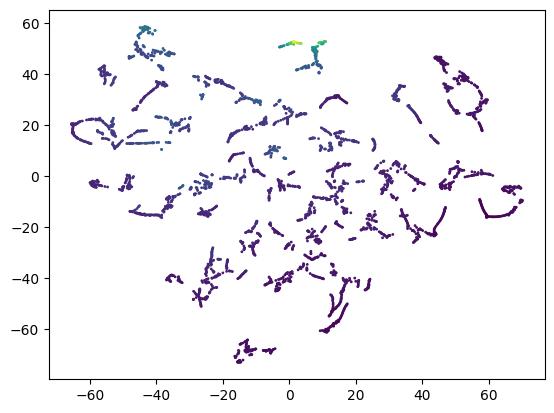

In [84]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["xs"][..., 0].squeeze().detach().numpy()
c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["diffusions"].mean(dim=-1).squeeze().detach().numpy()

arr = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["zs"]
arr = arr.detach().numpy()
arr = StandardScaler().fit_transform(arr)
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000)
out = tsne.fit_transform(arr)
plt.scatter(out[:, 0], out[:, 1], s=1, c=c)

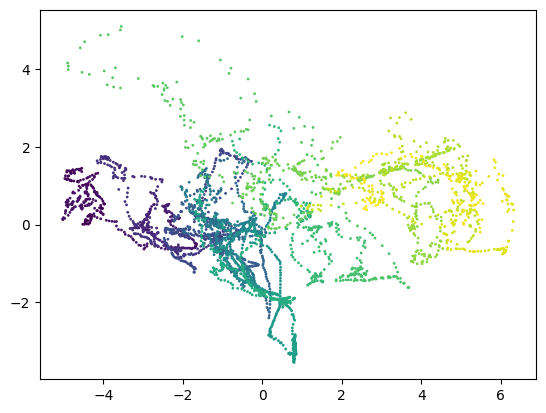

In [36]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["xs"][..., 0].squeeze().detach().numpy()
# c = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["diffusions"].mean(dim=-1).squeeze().detach().numpy()
c = np.arange(len(c))

arr = dataset_predictions[Path(dataset_list[idx].csv_file).stem]["zs"]
arr = arr.detach().numpy()
arr = StandardScaler().fit_transform(arr)
isomap = Isomap(n_components=2, n_neighbors=50)
out = isomap.fit_transform(arr)
plt.scatter(out[:, 0], out[:, 1], s=1, c=c)

In [40]:
# compute average latent state across all stocks, per month

latents_list = []
for dataset in dataset_list_good:
    df = pd.read_csv(dataset.csv_file)
    latents = dataset_predictions[Path(dataset.csv_file).stem]["zs"].squeeze()
    latents_list.append(pd.DataFrame(dict(
        latents_0=latents[:, 0],
        latents_1=latents[:, 1],
        latents_2=latents[:, 2],
        latents_3=latents[:, 3],
        latents_4=latents[:, 4],
        latents_5=latents[:, 5],
        date=df["Date"].iloc[:len(latents)],
    )))
latents_df = pd.concat(latents_list, axis=0)
latents_df["date"] = pd.to_datetime(latents_df["date"], utc=True)
latents_df["month"] = latents_df["date"].dt.month

In [41]:
latents_df = latents_df.drop("date", axis=1)
latents_df = latents_df.groupby("month").mean().reset_index()
latents_df = latents_df.set_index("month").values


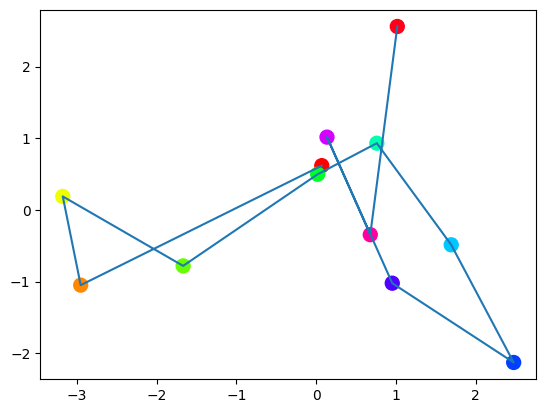

In [50]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

arr = latents_df
ss = StandardScaler()
arr = ss.fit_transform(arr)
pca = PCA(n_components=2)
arr = pca.fit_transform(arr)
plt.scatter(arr[:, 0], arr[:, 1], s=100, c=np.arange(12) / 12, cmap="hsv")
plt.plot(arr[:, 0], arr[:, 1])

In [51]:
import math

n_samples = 2
sample_len = 3500

generator = torch.Generator()
generator.manual_seed(0)
eps = torch.randn(size=(n_samples, *pl_module.model.pz0_mean.shape[1:]), generator=generator)
z0 = pl_module.model.pz0_mean + pl_module.model.pz0_logstd.exp() * eps

t = torch.arange(sample_len) / 50
zs = [z0]
for i in range(sample_len):
    prior_mean = zs[-1] + pl_module.model.alpha * pl_module.model.h(t, zs[-1])
    prior_std = math.sqrt(pl_module.model.alpha) * pl_module.model.g(t, zs[-1])
    prior_sample = prior_mean + prior_std * torch.randn(size=prior_mean.shape, generator=generator)
    zs.append(prior_sample)
zs = torch.stack(zs, dim=0).permute(1, 0, 2)

In [52]:
zs.shape

torch.Size([2, 3501, 6])

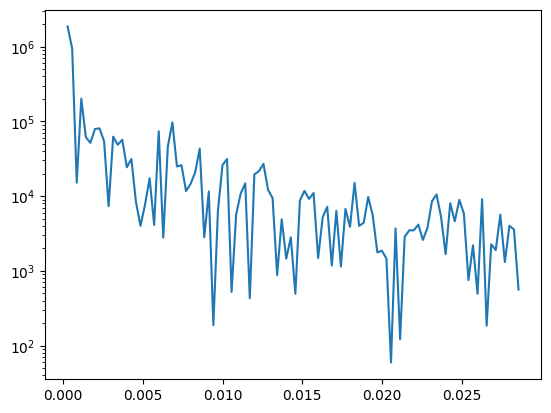

In [59]:


if isinstance(zs, torch.Tensor):
    zs = zs.detach().numpy()

data = zs[0, :, 0]
ps = np.abs(np.fft.fft(data))**2

time_step = 1
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)
idx = idx[freqs[idx] > 0]

plt.plot(freqs[idx][:100], ps[idx][:100])
plt.yscale("log")

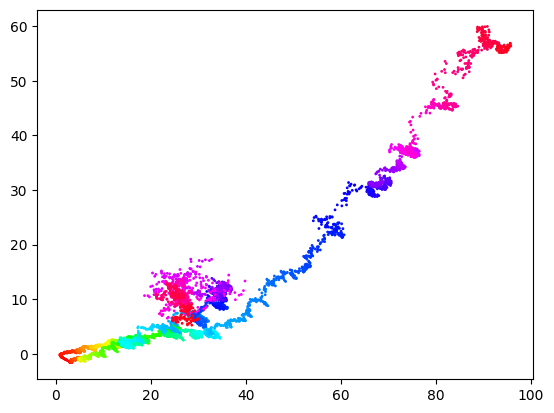

In [53]:
if isinstance(zs, torch.Tensor):
    zs = zs.detach().numpy()
zs_flat = zs.reshape(-1, 6)

arr = ss.transform(zs_flat)
arr = pca.transform(arr)
arr = arr.reshape(zs.shape[0], zs.shape[1], -1)

for i in range(arr.shape[0]):
    plt.scatter(arr[i, :, 0], arr[i, :, 1], s=1, c=np.arange(sample_len + 1) / sample_len, cmap="hsv")

In [54]:
latents_df

array([[-0.22213015,  1.5959778 ,  3.244818  ,  2.1237106 ,  1.2767129 ,
        -1.167418  ],
       [-0.28226113,  1.5978959 ,  3.219147  ,  2.0875468 ,  1.2880151 ,
        -1.1743268 ],
       [-0.21934995,  1.5983387 ,  3.2170963 ,  2.0826776 ,  1.2908343 ,
        -1.1852112 ],
       [-0.2688885 ,  1.5976902 ,  3.2297404 ,  2.1017966 ,  1.283614  ,
        -1.1817074 ],
       [-0.2554829 ,  1.5987446 ,  3.2408097 ,  2.1150455 ,  1.2621183 ,
        -1.1516141 ],
       [-0.228299  ,  1.5991225 ,  3.2426713 ,  2.1187031 ,  1.2491822 ,
        -1.1613904 ],
       [-0.21891834,  1.5979965 ,  3.2454736 ,  2.1268964 ,  1.2422308 ,
        -1.2241998 ],
       [-0.28453803,  1.5975323 ,  3.251769  ,  2.135144  ,  1.2353007 ,
        -1.229504  ],
       [-0.28794512,  1.5995756 ,  3.2422183 ,  2.1177497 ,  1.2435383 ,
        -1.1868086 ],
       [-0.20852374,  1.6001332 ,  3.236766  ,  2.1087143 ,  1.2525245 ,
        -1.1796486 ],
       [-0.24272074,  1.5988859 ,  3.2425318 ,  2.

In [55]:
zs

array([[[-0.49643758,  1.5499654 ,  3.202183  ,  1.9766679 ,
          1.4269837 ,  0.58286643],
        [-0.47368577,  1.5517633 ,  3.1979144 ,  1.9666743 ,
          1.4291196 ,  0.6028844 ],
        [-0.42412248,  1.5533097 ,  3.1931555 ,  1.9576966 ,
          1.4305314 ,  0.6245636 ],
        ...,
        [ 0.08457883,  1.5829245 ,  3.115215  ,  1.8084731 ,
          1.41598   ,  0.8829729 ],
        [ 0.08701299,  1.5830023 ,  3.114498  ,  1.807361  ,
          1.4202274 ,  0.8823458 ],
        [ 0.09531324,  1.583293  ,  3.1139855 ,  1.8058839 ,
          1.4193866 ,  0.88158923]],

       [[-0.21553433,  1.4912015 ,  3.329343  ,  1.7305312 ,
          1.3210703 ,  0.01802891],
        [-0.18533888,  1.4917825 ,  3.328046  ,  1.7272311 ,
          1.319544  ,  0.0262846 ],
        [-0.1406165 ,  1.4923033 ,  3.3266487 ,  1.7231712 ,
          1.3170314 ,  0.03282296],
        ...,
        [-0.00497109,  1.4887251 ,  3.316514  ,  1.7116302 ,
          1.2958832 , -0.12623705],
  